## Image classification with deep learning methods.

--- Description ---

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [4]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [5]:
# Install and import the MedMNIST package and datasets.

!pip install medmnist
import medmnist
from medmnist import info

     ---------------------------------------- 11.6/11.6 MB 6.4 MB/s eta 0:00:00
     ---------------------------------------- 87.2/87.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 507.9/507.9 kB 5.4 MB/s eta 0:00:00
     -------------------------------------- 347.8/347.8 kB 5.4 MB/s eta 0:00:00
Using legacy 'setup.py install' for fire, since package 'wheel' is not installed.
  Running setup.py install for fire: started
  Running setup.py install for fire: finished with status 'done'



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Download the imaging dataset

You can browse the imaging datasets on their webpage https://medmnist.com/, and download them as such:


In [19]:
from medmnist import OrganAMNIST

train_set = OrganAMNIST(split="train", download=True)
val_set = OrganAMNIST(split="val", download=True)
test_set = OrganAMNIST(split="test", download=True)

## Visualize the imaging dataset

You can find relevant information about the datasets in the info.INFO dictionary.

For visualizing the images, you can use the montage method, though we recomend
you practice accesing the individual images and labels.



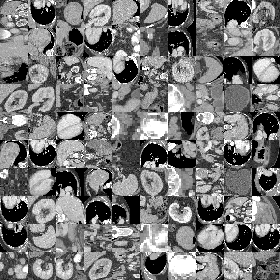

In [20]:
train_set.montage(length=10)

In [21]:
image, label = train_set[0]
print("Tamaño de la imagen:", np.array(image).shape)

Tamaño de la imagen: (28, 28)


# Generate a dataloader

A convinient option for accessing data in torch is with the use of the Dataloader class. These work directly when given a MNIST dataset as input.
You can also apply any necesary preprocesing steps directly as you load the data with the Transforms package and the transform MNIST argument.

Choose apropiate values for the training hiperparameters (you can experiment with sampling strategies if you want) and implement the adecuate preprocesing steps. Finally, choose an Mnist dataset and create the dataloader for the training, validation and test splits.

In [22]:
from medmnist import INFO, Evaluator

data_flag = 'organamnist'

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

im_size = 28
in_channels = 784
num_classes = 11

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

download = False

# Load and preprocess data
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


#Create a deep learning model

In [23]:
# Define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes, im_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * (im_size // 2) * (im_size // 2), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes, im_size=im_size)

# Para optimizar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

#Train Model

Implement the main traning loop to train the deep learning model.
This should include the forward and backward passes. You can find information about how to do this with torch in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id14

In [25]:
# Train the model

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device).float(), targets.to(device).view(-1).long()

        optimizer.zero_grad()  # Resetear gradientes
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Calcular pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

100%|██████████| 271/271 [01:01<00:00,  4.41it/s]


Epoch [1/3], Loss: 0.0754


100%|██████████| 271/271 [01:07<00:00,  3.99it/s]


Epoch [2/3], Loss: 0.0289


100%|██████████| 271/271 [01:14<00:00,  3.66it/s]

Epoch [3/3], Loss: 0.0113


#Evaluation

Finally, implement the evaluation of the object clasification task. You can implement any metric you want, though the most common are accuracy and AUC (one class against all for the multiclass task). You can use torch.no_grad() for speeding up predictions when no gradients are needed.

How do you compare with the MedMNIST benchmarks?

In [26]:
# Evaluation

model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device).float(), targets.to(device).squeeze().long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

accuracy = 100 * correct / total
auc = roc_auc_score(np.eye(n_classes)[all_targets], np.eye(n_classes)[all_preds], multi_class='ovr')

print(f"Accuracy: {accuracy:.2f}%")
print(f"AUC: {auc:.4f}")

Accuracy: 87.08%
AUC: 0.9236
